In [83]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [84]:
num_imgs = 70000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
print imgs.shape, bboxes.shape

(70000, 8, 8) (70000, 1, 4)


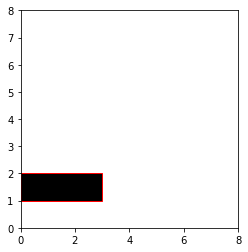

In [85]:
i = 2
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [86]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((70000, 64), -5.0594449265060702e-18, 0.99999999999999989)

In [87]:
# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((70000, 4), 0.28119241071428569, 0.17528762087406075)

In [88]:
# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [89]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [90]:
class LinearRegressionModel(nn.Module):
    def __init__(self,insize,ousize):
        super(LinearRegressionModel, self).__init__()
        self.linear1 = nn.Linear(inp_dim,200)
        #self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(200,out_dim)
    def forward(self, x):
        out = F.relu(self.linear1(x))
        #out = self.dropout(out)
        out = self.linear2(out)
        return out

In [91]:
inp_dim=64
out_dim=4

model=LinearRegressionModel(inp_dim,out_dim)

criterion = nn.MSELoss()
learning_rate=0.01
optimizer= torch.optim.Adam(model.parameters(),lr=learning_rate)

In [92]:
loss_list=[]
epochs = 1000
for epoch in range(epochs):
    epoch+=1
    
    inputs=Variable(torch.FloatTensor(train_X))
    labels=Variable(torch.FloatTensor(train_y))
    
    optimizer.zero_grad()
    
    outputs = model(inputs)
    #print outputs.data.numpy()
    #print inputs.data.numpy()
    loss=criterion(outputs,labels)
    
    loss.backward()
    
    optimizer.step()
    if epoch%100==0:
        print ('epoch {}, loss {}'.format(epoch,loss.data[0])) 
    loss_list.append(loss.data[0])

epoch 100, loss 8.0657977378e-05
epoch 200, loss 6.94841310178e-06
epoch 300, loss 9.91367755887e-07
epoch 400, loss 1.68999989114e-07
epoch 500, loss 3.10694332484e-08
epoch 600, loss 5.8100342315e-09
epoch 700, loss 1.05185671284e-09
epoch 800, loss 1.85037901668e-10
epoch 900, loss 2.98142691091e-11
epoch 1000, loss 4.25626461159e-12


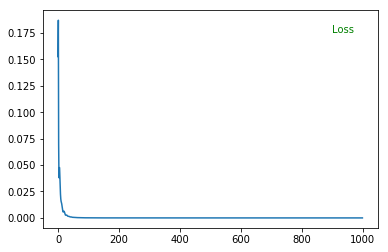

In [103]:
plt.plot(loss_list)
plt.text(900, 0.175, 'Loss', fontdict={'size': 10, 'color':  'green'})
plt.show()

In [93]:
inputs=Variable(torch.FloatTensor(test_X))
labels=Variable(torch.FloatTensor(test_y))
outputs = model(inputs)
pred_y = outputs.data.numpy()
            
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(14000, 1, 4)

In [94]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

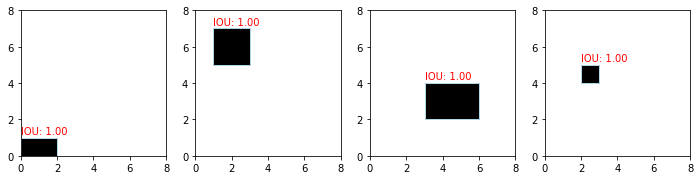

In [95]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.gca().add_patch(matplotlib.patches.Rectangle((exp_bbox[0], exp_bbox[1]), exp_bbox[2], exp_bbox[3], color='lightblue', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
        
# plt.savefig('plots/bw-single-rectangle_prediction.png', dpi=300)

In [98]:
input1=Variable(torch.FloatTensor(test_X[]))
labels1=Variable(torch.FloatTensor(test_y[1]))
outputs1 = model(input1)
print outputs1, labels1

Variable containing:
 0.3750
 0.6250
 0.1250
 0.1250
[torch.FloatTensor of size 4]
 Variable containing:
 0.3750
 0.6250
 0.1250
 0.1250
[torch.FloatTensor of size 4]



In [99]:
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.99998360718840895

In [104]:
torch.save(model.state_dict(), 'singlebox_model_chk.pt')